### Start

In [221]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [293]:
def Min_Max(data):
    data = data.to_numpy()

    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    return data

In [294]:
# 读取数据
Monday = pd.read_csv('Mon.csv')
Monday.loc[Monday['Label'] == 'BENIGN', "Label_test"] = 1

applicable_features = [
    "td",
    "sa_1","sa_2","sa_3","sa_4",
    "da_1","da_2","da_3","da_4",
    "sp", "dp",
    "pr",
    "ipkt","ibyt","opkt","obyt",
    "Label_test"]

M = Monday[applicable_features]

for features in applicable_features[:-1]:
    M[features] = Min_Max(M[features])

# 提取正样本，并且按照8:2切成训练集和测试集
mask = (M['Label_test'] == 1)
X_train, X_test = train_test_split(M[mask], test_size=0.2, random_state=920)
X_train = X_train.drop(['Label_test'], axis=1).values
X_test = X_test.drop(['Label_test'], axis=1).values

/tmp/ipykernel_219492/2287350275.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M[features] = Min_Max(M[features])


In [392]:
# 设置Autoencoder的参数
# 隐藏层节点数分别为 input -> 16，8，16
# epoch为3，batch size为320
input_dim = X_train.shape[1]
encoding_dim = 16
num_epoch = 3
batch_size = 320

input_layer = Input(shape=(input_dim, ))
# 五层结构:X -> 16 -> 8 -> 16 -> X'
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) #16
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder) # 8
decoder = Dense(int(encoding_dim), activation='tanh')(encoder) # 16
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="_model.h5",
                               verbose=0,
                               save_best_only=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history

# 67 -- 0.3481

Epoch 1/3
1325/1325 [==============================] - 7s 5ms/step - loss: 0.0444 - mae: 0.0895 - val_loss: 0.0051 - val_mae: 0.0330
Epoch 2/3
1325/1325 [==============================] - 6s 5ms/step - loss: 0.0037 - mae: 0.0277 - val_loss: 0.0034 - val_mae: 0.0272
Epoch 3/3
1325/1325 [==============================] - 6s 5ms/step - loss: 0.0026 - mae: 0.0231 - val_loss: 0.0019 - val_mae: 0.0186


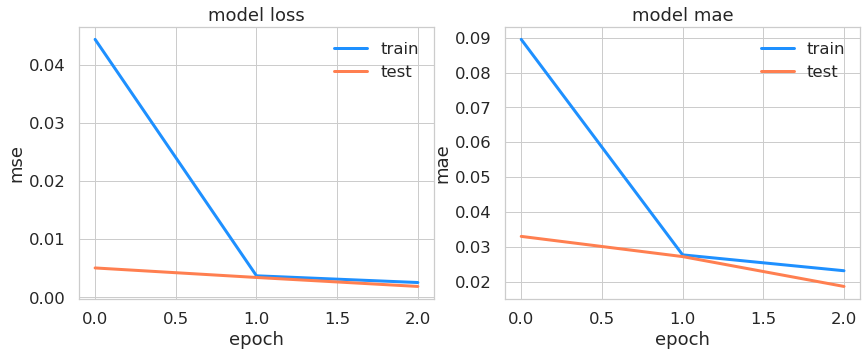

In [393]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.plot(history['val_mae'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [435]:
def test(filename):
    # 阈值为0.03
    threshold = 0.03
    # 读取模型
    autoencoder = load_model('_model.h5')
    Tuesday = pd.read_csv(filename)
    Tuesday.loc[Tuesday['Label'] == 'BENIGN', "Label_test"] = 1
    Tuesday.loc[Tuesday['Label'] != 'BENIGN', "Label_test"] = 0


    T = Tuesday[applicable_features]

    for features in applicable_features[:-1]:
        T[features] = Min_Max(T[features])

    X_test = T
    y_test = X_test['Label_test'] # Y test 
    X_test = X_test.drop(['Label_test'], axis=1)
    X_test = X_test.values

    # 预测周二的test 数据为89182 里面包含了正常和不正常

    predictions = autoencoder.predict(X_test)
    mae = np.mean(np.abs(X_test - predictions), axis=1)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error': mse,
                            'true_class': y_test})
    error_df.describe()

    print((filename.strip('.csv')),'/ dataset ', y_test.shape)
    print('Normal Data Volume : ',np.sum(y_test.values))
    print('Attack Data Volume : ',y_test.shape[0] - np.sum(y_test.values))
    


    TP = 0
    TN = 0
    for i in range(mse.shape[0]):
        if mse[i] <= threshold: # 0.03 - 0.05 0.025 
            if y_test.values[i] == 1:
                TP += 1
        else:
            if y_test.values[i] == 0:
                TN += 1

    print(TP, ' / ',TN)
    print('Predict Normal Data Volume ：', TP)
    print('Predict Attack Data Volume ：', TN)
    acc = (TP+TN)/y_test.shape[0]



    print('acc : ', acc)

    y_pred = []
    

    for e in error_df.reconstruction_error.values:
        if e <= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    # print(y_pred)
    
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    plt.figure(figsize=(12, 12))
    LABELS = ["Attack","Normal"]
    
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    return acc

In [432]:
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)


/tmp/ipykernel_219492/4017595218.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T[features] = Min_Max(T[features])


Tue / dataset  (445909,)
Normal Data Volume :  432074.0
Attack Data Volume :  13835.0
430735  /  13835
Predict Normal Data Volume ： 430735
Predict Attack Data Volume ： 13835
acc :  0.99699714515742
tn - >  13835  tp - >  430735


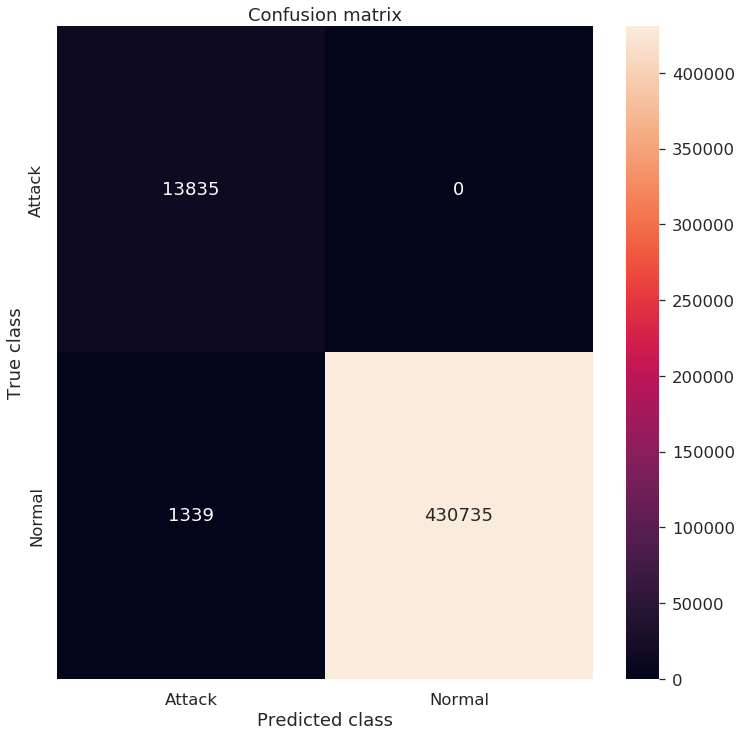

/tmp/ipykernel_219492/4017595218.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T[features] = Min_Max(T[features])


Wed / dataset  (692703,)
Normal Data Volume :  440031.0
Attack Data Volume :  252672.0
435281  /  252672
Predict Normal Data Volume ： 435281
Predict Attack Data Volume ： 252672
acc :  0.9931428043476064
tn - >  252672  tp - >  435281


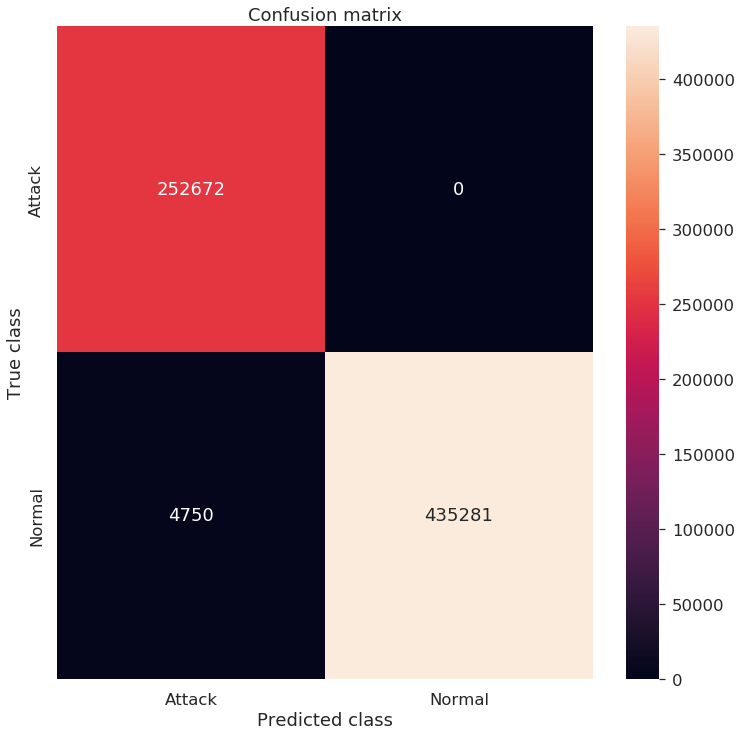

/tmp/ipykernel_219492/4017595218.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T[features] = Min_Max(T[features])


Thu / dataset  (458968,)
Normal Data Volume :  456752.0
Attack Data Volume :  2216.0
454417  /  2180
Predict Normal Data Volume ： 454417
Predict Attack Data Volume ： 2180
acc :  0.994834062505447
tn - >  2180  tp - >  454417


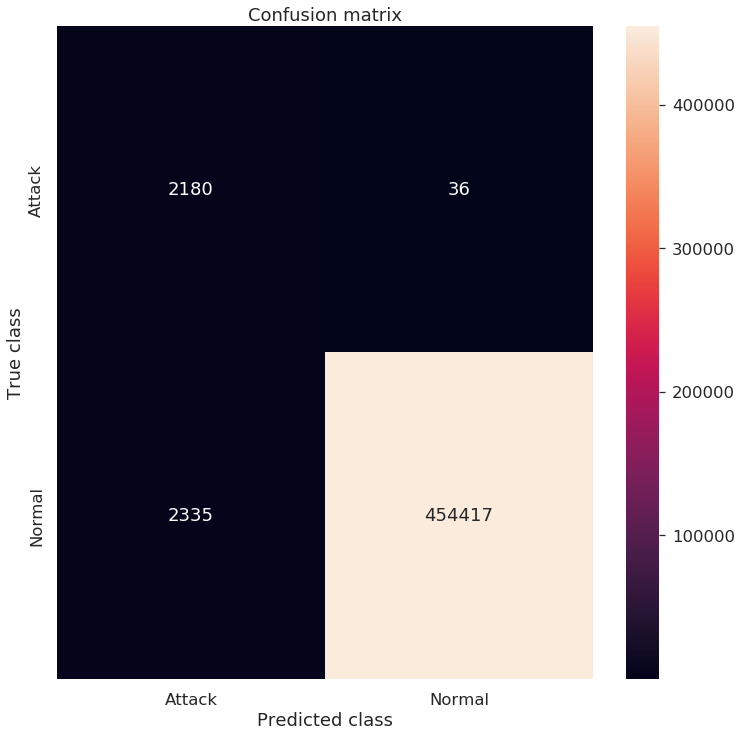

/tmp/ipykernel_219492/4017595218.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T[features] = Min_Max(T[features])


Fri / dataset  (703245,)
Normal Data Volume :  414322.0
Attack Data Volume :  288923.0
404545  /  273772
Predict Normal Data Volume ： 404545
Predict Attack Data Volume ： 273772
acc :  0.9645528940838541
tn - >  273772  tp - >  404545


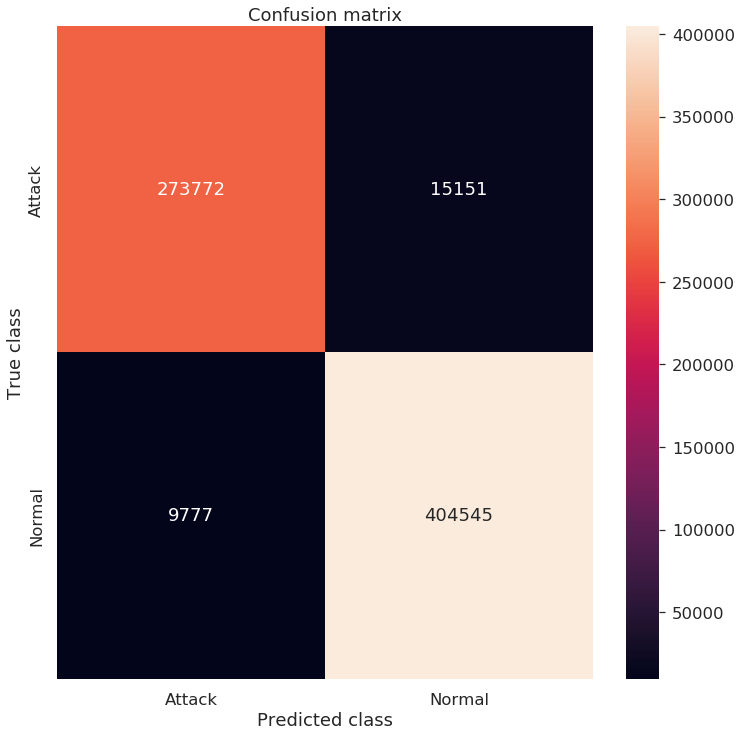

In [434]:
days = ['Tue.csv','Wed.csv','Thu.csv','Fri.csv']
mean_acc = 0
for day in days:
    Acc = test(day)
    mean_acc += Acc
    
    
    


In [424]:
print('Average Accuracy: ',mean_acc / 4)

Average Accuracy:  0.9873817265235818


In [404]:
days = ['Mon.csv','Tue.csv','Wed.csv','Thu.csv','Fri.csv']
for day in days:
    print("Loading raw data ... ")
    print()
    print(day.strip('.csv'))
    raw_data = pd.read_csv(day, header=None, low_memory=False)

    last_column_index = raw_data.shape[1] - 1

    print("print data labels : ")
    print(raw_data[last_column_index].value_counts())
    print("===============================")
    print()

Loading raw data ... 

Mon
print data labels : 
BENIGN    529918
Label          1
Name: 16, dtype: int64

Loading raw data ... 

Tue
print data labels : 
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Label               1
Name: 16, dtype: int64

Loading raw data ... 

Wed
print data labels : 
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Label                    1
Name: 16, dtype: int64

Loading raw data ... 

Thu
print data labels : 
BENIGN                      456752
Web Attack-Brute Force        1507
Web Attack-XSS                 652
Infiltration                    36
Web Attack-Sql Injection        21
Label                            1
Name: 16, dtype: int64

Loading raw data ... 

Fri
print data labels : 
BENIGN      414322
PortScan    158930
DDoS        128027
Bot           1966
Label            1
Name: 16, dtype: int64

